## Importing Libraries
json and os are used to read files
matplotlib and seaborn is used to plot data and imges
cv2 and PIL is used for image processing
sklearn is used to select random images for train and test data
tensorflow and keras are used to build neural networks
scipy is used for image processing

In [1]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
import cv2 , PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import keras
import seaborn as sns
from scipy.signal import find_peaks

In [2]:
imagefiles = os.listdir("images/")
imagefiles = shuffle(imagefiles)

In [3]:
def resize(img):
    img = PIL.Image.fromarray(img)
    resized_im = img.resize((400,400))
    open_cv_image = np.array(resized_im) 
    return open_cv_image

In [4]:
N = 20000

## Reading Images from train/images folder

In [5]:
X = []
Y = []

img = np.array(imagefiles)[np.random.randint(low=0,high=len(imagefiles),size=N)]
for i in list(img):
    img = cv2.imread(f"images/{i}",0)
    X.append(img)
    f = open(f"annotations/{i[:-4]}.json")
    l = json.load(f)
    Y.append(l["chart-type"])

In [6]:
Y = np.array(Y)
U = np.unique(Y)
for i in range(U.shape[0]):
    Y[Y == U[i]] = i
Y = Y.astype(int)

dot 1769
line 8257
scatter 3623
vertical_bar 6351


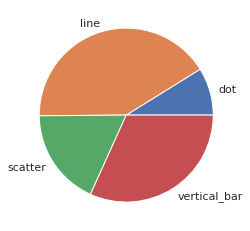

In [7]:
for i in range(U.shape[0]):
    print(U[i],Y[Y == i].shape[0])
sns.set(style="whitegrid")
plt.pie(list(Y[Y == i].shape[0] for i in range(U.shape[0])), labels=U)  
plt.show()

## Extract Graph from Img

In [8]:
def GraphExtract(img,h=150):
    imgEdges = cv2.Canny(img,threshold1=20,threshold2=40)
    l = np.mean(imgEdges,axis=0)
    firstPeaks = find_peaks(l[15:],prominence = h)[0]
    if(len(firstPeaks) != 0 and firstPeaks[0] < l.shape[0] / 2): 
        return img[:,firstPeaks[0]+15:]
    else:
        return GraphExtract(img,h*.8)    
    
def preprocessing(img):
    if(np.mean(img) < 100): img = ~img
    imgY = GraphExtract(img[::-1].T).T[::-1]
    imgX = GraphExtract(imgY,h=118)
    imgX = imgX[int(imgX.shape[0]*.3):,:]
    return (imgX, cv2.Canny(img,threshold1=20,threshold2=70))

### Example

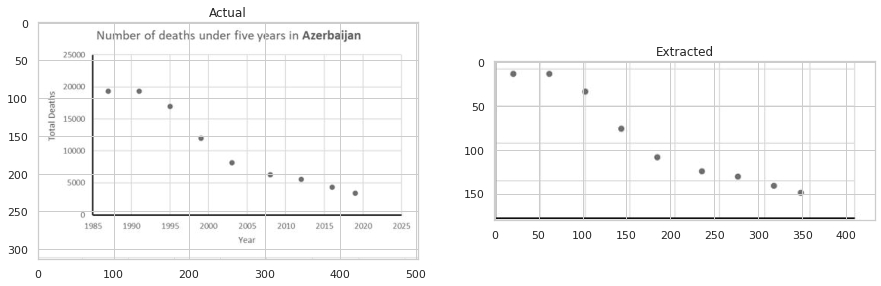

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.title("Actual")

plt.subplot(1,2,2)
plt.imshow(preprocessing(X[0])[0],cmap='gray')
plt.title("Extracted")

plt.show()

## Making Features Vector from Images

In [10]:
def makeVector(img):
    imgs = preprocessing(img)
    img = imgs[0]
    y = np.mean(img,axis=0)
    x = np.mean(img,axis=1)
    f = np.abs(np.fft.rfft(y[10:-10]).real[10:-10])
    g = np.abs(np.fft.rfft(x[10:-10]).real[10:-10])
    l1 = [np.std(img),
         np.mean(y),
         np.std(y),
         np.mean(x),
         np.std(x),
         np.where(f == np.max(f))[0][0],
         np.max(f),
         np.mean(f),
         np.std(f),
         np.std(g),
         np.mean(g),
         np.where(g == np.max(g))[0][0],
         np.max(g),
    ]
    img = imgs[1]
    y = np.mean(img,axis=0)
    x = np.mean(img,axis=1)
    f = np.abs(np.fft.rfft(y[10:-10]).real[10:-10])
    g = np.abs(np.fft.rfft(x[10:-10]).real[10:-10])
    l2 = [np.std(img),
         np.mean(y),
         np.std(y),
         np.mean(x),
         np.std(x),
         np.where(f == np.max(f))[0][0],
         np.max(f),
         np.mean(f),
         np.std(f),
         np.std(g),
         np.mean(g),
         np.where(g == np.max(g))[0][0],
         np.max(g),
    ]    
    
    return np.array(list(l1+l2))

### Converting Images to Features Vectors

In [11]:
X_ = []
Y_ = []
for i in range(len(X)):
    X_.append(makeVector(X[i]))
    Y_.append(Y[i])
    
X_ = np.array(X_)
Y_ = np.array(Y_)

In [12]:
print("X shape :",X_.shape)
print("Y shape :",Y_.shape)

X shape : (20000, 26)
Y shape : (20000,)


### Seperating training and test samples

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_,Y_,test_size=.5)  
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Neutral Networks

In [14]:
model = keras.Sequential([
    keras.Input(shape=x_train[0].shape),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(U.shape[0],activation='softmax')
])

In [15]:
y_train = np.int32(y_train)
model.compile(optimizer=keras.optimizers.Adam(.001),loss='sparse_categorical_crossentropy')
model.fit(x=x_train,y=y_train,epochs=50)
model.compile(optimizer=keras.optimizers.Adam(.0001),loss='sparse_categorical_crossentropy')
model.fit(x=x_train,y=y_train,epochs=50)

Epoch 1/50
313/313 [==============================] - 1s 756us/step - loss: 10.1932
Epoch 2/50
313/313 [==============================] - 0s 632us/step - loss: 2.4108
Epoch 3/50
313/313 [==============================] - 0s 666us/step - loss: 1.8933
Epoch 4/50
313/313 [==============================] - 0s 674us/step - loss: 1.6299
Epoch 5/50
313/313 [==============================] - 0s 725us/step - loss: 1.6593
Epoch 6/50
313/313 [==============================] - 0s 678us/step - loss: 1.2769
Epoch 7/50
313/313 [==============================] - 0s 915us/step - loss: 1.0924
Epoch 8/50
313/313 [==============================] - 0s 704us/step - loss: 1.1402
Epoch 9/50
313/313 [==============================] - 0s 617us/step - loss: 0.7454
Epoch 10/50
313/313 [==============================] - 0s 602us/step - loss: 1.0898
Epoch 11/50
313/313 [==============================] - 0s 611us/step - loss: 0.7996
Epoch 12/50
313/313 [==============================] - 0s 847us/step - loss: 0.7747


313/313 [==============================] - 0s 600us/step - loss: 0.0254
Epoch 50/50
313/313 [==============================] - 0s 592us/step - loss: 0.0235


## Errors

In [16]:
y_predicted = np.argmax(model.predict(x_test),axis = 1)
errors = np.int32(y_predicted != y_test)
print("error percentage: ",np.sum(errors)/errors.shape[0])
print("accuracy percentage: ",1- np.sum(errors)/errors.shape[0])

313/313 [==============================] - 0s 546us/step
error percentage:  0.0149
accuracy percentage:  0.9851


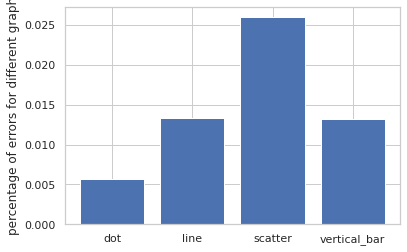

In [17]:
err = list(np.sum(errors[y_test == i])/np.sum(y_test == i) for i in range(U.shape[0]))
plt.bar(U,err)
plt.ylabel("percentage of errors for different graph")
plt.show()

dot  : 880
line  : 4144
scatter  : 1811
vertical_bar  : 3165


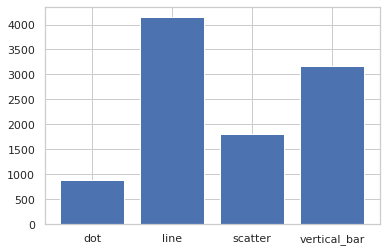

In [18]:
s = list(y_test[y_test == i].shape[0] for i in range(U.shape[0]))
for i in range(U.shape[0]):
    print(U[i]," :",s[i],)
plt.bar(U,s)
plt.show()